# 评价时间与星级分布

In [142]:
import pandas as pd 
import numpy as np
import time
import re 
import itertools
import jieba.posseg as psg
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora, models
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决中文乱码问题
plt.rcParams['axes.unicode_minus'] = False # 解决负号无法正常显示的问题
%config InlineBackend.figure_format = 'svg' # 将图标设置成矢量图格式显示，会更清晰
plt.style.use('Solarize_Light2') # 设置绘图样式

In [115]:
data = pd.read_csv('../data/comments.csv',encoding='utf8')
data.head()

,ID,评论时间,评论星级,评论内容
0,2357224095,1591534245853,50,之前就听朋友说过很多次一直没有时间来，自驾游从贵阳出发，做了下攻略漂流完又去镇远古镇，西江千...
1,2394943165,1594192959256,50,是一个非常好玩的地方 适合减压 适合约会 适合夏天 激流的地方还是挺多的 不错 就是一定要做...
2,2344539215,1590637677803,40,【餐饮】去漂流的途中记得先吃点东西 因为到了景区换衣服坐大巴还要一段距离 5月12日去的漂流...
3,2395379606,1594175852563,40,不错 很好玩 有点意犹未尽的感觉 就是东西有点贵 比如手机袋最好买了在去
4,2407348024,1594952354482,30,全程下来两个小时多一点感觉还不错，但是大家一定要早点过去，然后挑天气好一点，太阳大一点，不然...


评论时间为时间戳的形式，需要转成年月日，按照年时间序列绘制每年评论数走势，并绘制箱型图查看评论主要分布在几月份，绘制评分分布箱型图

In [116]:
# 时间戳转时间
def stampToTime(stamp): #时间转换
    datatime = time.strftime("%Y-%m-%d %H:%M",time.localtime(float(str(stamp)[0:10])))
    return datatime

data['评论时间'] = data['评论时间'].map(stampToTime)
data.head()

,ID,评论时间,评论星级,评论内容
0,2357224095,2020-06-07 20:50,50,之前就听朋友说过很多次一直没有时间来，自驾游从贵阳出发，做了下攻略漂流完又去镇远古镇，西江千...
1,2394943165,2020-07-08 15:22,50,是一个非常好玩的地方 适合减压 适合约会 适合夏天 激流的地方还是挺多的 不错 就是一定要做...
2,2344539215,2020-05-28 11:47,40,【餐饮】去漂流的途中记得先吃点东西 因为到了景区换衣服坐大巴还要一段距离 5月12日去的漂流...
3,2395379606,2020-07-08 10:37,40,不错 很好玩 有点意犹未尽的感觉 就是东西有点贵 比如手机袋最好买了在去
4,2407348024,2020-07-17 10:19,30,全程下来两个小时多一点感觉还不错，但是大家一定要早点过去，然后挑天气好一点，太阳大一点，不然...


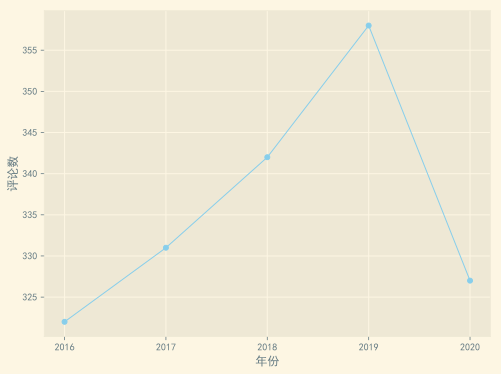

In [117]:
# 取出时间中的年份并按照年份计数排序
time_year = data['评论时间'].apply(lambda x: x.split('-')[0]).value_counts()
year = list(time_year.index)
count = (time_year.values)
time_year = list(zip(year,count))
time_year = sorted(time_year,key=lambda x: x[0])

# 绘制折线图
x = [time[0] for time in time_year]
y = [time[1] for time in time_year]
fig = plt.figure(figsize=(8,6))
plt.plot(x,y,color='skyblue',linewidth=1,marker='o',markersize=5)
plt.xlabel('年份')
plt.ylabel('评论数')
plt.savefig('../output/评论数走势')
plt.show()

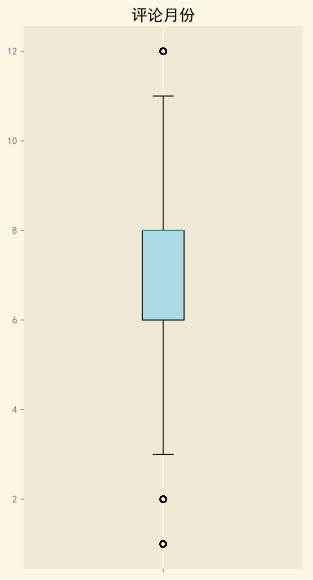

In [118]:
# 取出月份并绘制在评论月份分布箱型图
time_month = data['评论时间'].apply(lambda x: int(x.split('-')[1]))
fig = plt.figure(figsize=(5,10))
plt.boxplot(time_month,patch_artist=True,labels=[''],
            boxprops={'facecolor':'lightblue'})
plt.title('评论月份')
plt.grid(axis='y')
plt.savefig('../output/评论月份分布箱型图')
plt.show()

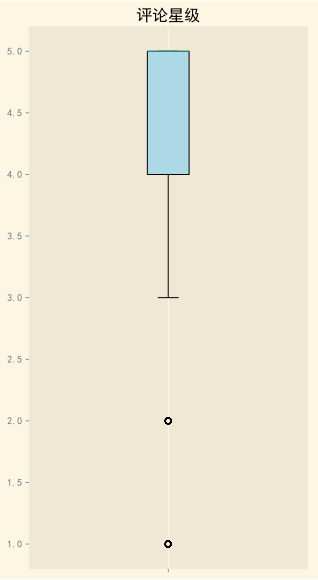

In [119]:
# 绘制评分分布箱型图
def score(s):
    '''
    把评分转换为1,2，,3，,4，,5这种形式
    '''
    if s == 10:
        s = 1
    if s == 20: 
        s = 2 
    if s == 30: 
        s = 3 
    if s == 40: 
        s = 4 
    if s == 50: 
        s = 5 
    return s
    
data['评论星级'] = data['评论星级'].map(score)
fig = plt.figure(figsize=(5,10))
plt.boxplot(data['评论星级'],patch_artist=True,labels=[''],
            boxprops={'facecolor':'lightblue'})
plt.title('评论星级')
plt.grid(axis='y')
plt.savefig('../output/评论星级分布箱型图')
plt.show()

# 删除重复的数据 

思考可能有恶意刷评论的用户，评论内容相差无几的，有的评论相似度极高，词语运用存在差异，删除则可能误删，所以只删除完全重复的

In [120]:
display(data.shape)
comments = data[['ID','评论内容']].drop_duplicates()
display(comments.shape)

(1680, 4)

(1680, 2)

# 删除缺失值

经手工查看数据，源数据有几百条评论为空的数据，这不是爬虫的锅，查看美团的原始数据发现，后面的评论数据根本就没有，但景点那里却写着1680条评论，实际只有952条评论

In [121]:
comments = comments.dropna()
comments.shape

(952, 2)

# 剔除夹杂的字符

字母数字这些没有什么用，由于是情感分析，数据中可能夹杂着‘美团’‘漂流’‘景点’等没用却出现的高频词，需要删除

In [122]:
str_re = re.compile('[a-zA-Z0-9]|美团|漂流|景点|高过河')
comments['评论内容'] = comments['评论内容'].apply(lambda x: str_re.sub('',x))

# 分词，词性标注，去除停用词

In [123]:
# 把每条评论分词，并标注每个词的词性
worker = lambda s: [(x.word,x.flag) for x in psg.cut(s)] # 自定义简单分词函数
seg_word = comments['评论内容'].apply(worker)
seg_word.head()

0    [(之前, f), (就, d), (听, v), (朋友, n), (说, v), (过,...
1    [(是, v), (一个, m), (非常, d), (好玩, v), (的, uj), (...
2    [(【, x), (餐饮, n), (】, x), (去, v), (的, uj), (途中...
3    [(不错, a), ( , x), ( , x), (很, zg), (好玩, v), ( ...
4    [(全程, n), (下来, t), (两个, m), (小时, n), (多一点, m),...
Name: 评论内容, dtype: object

In [124]:
# 每一条评论中的词的个数
n_word = seg_word.apply(lambda x: len(x))

# 把每条评论的 id 弄成列表，例如第一条评论 id 为 1，有 3 个分词，第二条评论 id 为 2，
# 两个分词，那结果：[[1,1,1],[2,2]] 以此类推
n_content = [[x+1]*y for x,y in zip(list(seg_word.index),list(n_word))]
index_content = sum(n_content,[]) # 将嵌套列表展开，作为词所在评论 id

In [125]:
seg_word = sum(seg_word,[]) # 列表。形式：[(词，词性)....]
word = [x[0] for x in seg_word] # 词
nature = [x[1] for x in seg_word] # 词性

In [126]:
# 转为数据框，第一列为词所在评论id，第二列词语，第三列词性
result = pd.DataFrame({'index_content':index_content,
                       'word':word,
                       'nature':nature,
                       })
result.head()

,index_content,word,nature
0,1,之前,f
1,1,就,d
2,1,听,v
3,1,朋友,n
4,1,说,v


In [127]:
# 词性为 x，代表标点符号，删除
result = result[result['nature'] != 'x']

In [128]:
# 删除停用词
stop_path = open('../data/stoplist.txt','r',encoding='utf8')
stop = stop_path.readlines()
stop = [x.replace('\n','') for x in stop]
word = list(set(word) - set(stop))
result = result[result['word'].isin(word)]

In [129]:
# 构造各词在对应评论的位置列
n_word = list(result.groupby('index_content')['index_content'].count())
index_word = [list(np.arange(0, y)) for y in n_word]
index_word = sum(index_word, [])  # 表示词语在该评论的位置

# 合并评论id，评论中词的id，词，词性
result['index_word'] = index_word
result.head()

,index_content,word,nature,index_word
2,1,听,v,0
3,1,朋友,n,1
10,1,时间,n,2
13,1,自驾游,i,3
15,1,贵阳,ns,4


# 提取名词，形容词

目标是对有课体验进行分析，评论中出现明确的名词形容词，才有意义，所以进行词性标注；n 代表名词，adj 代表形容词，先选出名词形容词所在的行，在选择索引，再根据索引从上面合并的结果中选出此条评论的所有词语

In [130]:
ind = result[[('n' in x) or ('adj' in x) for x in result['nature']]]['index_content'].unique()
result = result[[x in ind for x in result['index_content']]]

# 绘制词云，查看分词效果

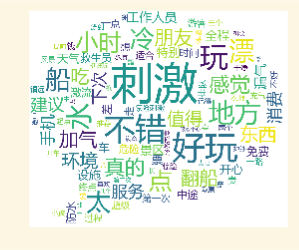

In [131]:
frequencies = result.groupby(by = ['word'])['word'].count()
frequencies = frequencies.sort_values(ascending = False)
backgroud_Image=plt.imread('../data/pl.jpg')
wordcloud = WordCloud(font_path="msyh.ttc",
                      max_words=100,
                      background_color='white',
                      mask=backgroud_Image)
my_wordcloud = wordcloud.fit_words(frequencies)
plt.imshow(my_wordcloud)
plt.axis('off')
plt.savefig('../output/综合情感词云')
plt.show()

# 将结果写出
result.to_csv("../output/word.csv",index=False,encoding='utf-8')

# 匹配情感词

情感词表是2007年知网发布的’情感分析用词语集‘，主要使用’中文正面评价‘，’中文正面情感‘，
’中文负面情感‘，’中文负面评价‘等词表
’中文正面评价‘，’中文正面情感‘合并，并个每个词语赋予出事权重为1，作为正面评论情感词表
’中文负面情感‘，’中文负面评价‘合并，并个每个词语赋予出事权重为-1，作为负面评论情感词表
在提供的词表基础上进行优化，添加一些词

In [132]:
word = result

# 读入正面、负面情感评价词
pos_comment = pd.read_csv("../data/正面评价词语（中文）.txt", header=None,sep="\n",
                          encoding = 'utf-8', engine='python')
neg_comment = pd.read_csv("../data/负面评价词语（中文）.txt", header=None,sep="\n",
                          encoding = 'utf-8', engine='python')
pos_emotion = pd.read_csv("../data/正面情感词语（中文）.txt", header=None,sep="\n",
                          encoding = 'utf-8', engine='python')
neg_emotion = pd.read_csv("../data/负面情感词语（中文）.txt", header=None,sep="\n",
                          encoding = 'utf-8', engine='python')

In [133]:
# 合并情感词与评价词
positive = set(pos_comment.iloc[:,0])|set(pos_emotion.iloc[:,0])
negative = set(neg_comment.iloc[:,0])|set(neg_emotion.iloc[:,0])
intersection = positive&negative  # 正负面情感词表中相同的词语
positive = list(positive - intersection)
negative = list(negative - intersection)
positive = pd.DataFrame({"word":positive,
                         "weight":[1]*len(positive)})
negative = pd.DataFrame({"word":negative,
                         "weight":[-1]*len(negative)})

In [134]:
# 将正负情感表进行合并
posneg = positive.append(negative)

#  将分词结果与正负面情感词表合并，定位情感词
data_posneg = posneg.merge(word, left_on = 'word', right_on = 'word',
                           how = 'right')
data_posneg = data_posneg.sort_values(by = ['index_content','index_word'])

# 修正情感倾向

主要根据情感词前面两个位置的词语是否存在否定词而去判断情感值的正确与否，即当否定词出
现奇数次时，表示否定；偶数表示肯定。按照汉语习惯，搜索每个情感词前两个词语，若为奇数
则调整为相反的情感极佳

In [135]:
# 载入否定词表
notdict = pd.read_csv("../data/not.csv")

# 处理否定修饰词
data_posneg['amend_weight'] = data_posneg['weight']  # 构造新列，作为经过否定词修正后的情感值
data_posneg['id'] = np.arange(0, len(data_posneg))
only_inclination = data_posneg.dropna()  # 只保留有情感值的词语
only_inclination.index = np.arange(0, len(only_inclination))
index = only_inclination['id']

for i in np.arange(0, len(only_inclination)):
    review = data_posneg[data_posneg['index_content'] ==
                         only_inclination['index_content'][i]]  # 提取第i个情感词所在的评论
    review.index = np.arange(0, len(review))
    affective = only_inclination['index_word'][i]  # 第i个情感值在该文档的位置
    if affective == 1:
        ne = sum([i in notdict['term'] for i in review['word'][affective - 1]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = - \
                data_posneg['weight'][index[i]]
    elif affective > 1:
        ne = sum([i in notdict['term'] for i in review['word'][[affective - 1,
                                                                affective - 2]]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = - \
                data_posneg['weight'][index[i]]

# 更新只保留情感值的数据
only_inclination = only_inclination.dropna()

# 计算每条评论的情感值
emotional_value = only_inclination.groupby(['index_content'],
                                           as_index=False)['amend_weight'].sum()

# 去除情感值为0的评论
emotional_value = emotional_value[emotional_value['amend_weight'] != 0]

# 绘制正面与负面情感词云

In [136]:
# 给情感值大于0的赋予评论类型为pos,小于0的为neg
emotional_value['a_type'] = ''
emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'

D:\programming\dev_env\anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\programming\dev_env\anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [137]:
# 查看情感分析结果
result = emotional_value.merge(word,
                               left_on = 'index_content',
                               right_on = 'index_content',
                               how = 'left')

result = result[['index_content', 'a_type']].drop_duplicates()

# 提取正负面评论信息
ind_pos = list(emotional_value[emotional_value['a_type'] == 'pos']['index_content'])
ind_neg = list(emotional_value[emotional_value['a_type'] == 'neg']['index_content'])
posdata = word[[i in ind_pos for i in word['index_content']]]
negdata = word[[i in ind_neg for i in word['index_content']]]

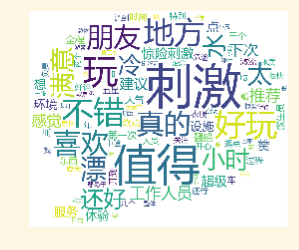

In [138]:
# 正面情感词词云
freq_pos = posdata.groupby(by = ['word'])['word'].count()
freq_pos = freq_pos.sort_values(ascending = False)
backgroud_Image=plt.imread('../data/pl.jpg')
wordcloud = WordCloud(font_path="msyh.ttc",
                      max_words=100,
                      background_color='white',
                      mask=backgroud_Image)
pos_wordcloud = wordcloud.fit_words(freq_pos)
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.savefig('../output/正面情感词云')
plt.show()

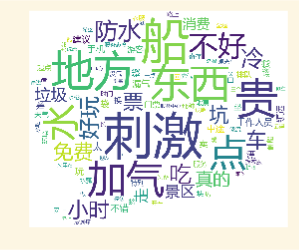

In [139]:
# 负面情感词词云
freq_neg = negdata.groupby(by = ['word'])['word'].count()
freq_neg = freq_neg.sort_values(ascending = False)
neg_wordcloud = wordcloud.fit_words(freq_neg)
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.savefig('../output/负面情感词云')
plt.show()

In [140]:
# 将结果写出,每条评论作为一行
posdata.to_csv("../output/posdata.csv", index = False, encoding = 'utf-8')
negdata.to_csv("../output/negdata.csv", index = False, encoding = 'utf-8')

# LDA 主题分析

建立词典及语料库

In [144]:
# 载入情感分析后的数据
posdata = pd.read_csv("../output/posdata.csv", encoding = 'utf-8')
negdata = pd.read_csv("../output/negdata.csv", encoding = 'utf-8')

# 建立词典
pos_dict = corpora.Dictionary([[i] for i in posdata['word']])  # 正面
neg_dict = corpora.Dictionary([[i] for i in negdata['word']])  # 负面

# 建立语料库
pos_corpus = [pos_dict.doc2bow(j) for j in [[i] for i in posdata['word']]]  # 正面
neg_corpus = [neg_dict.doc2bow(j) for j in [[i] for i in negdata['word']]]   # 负面

寻找最优主题数

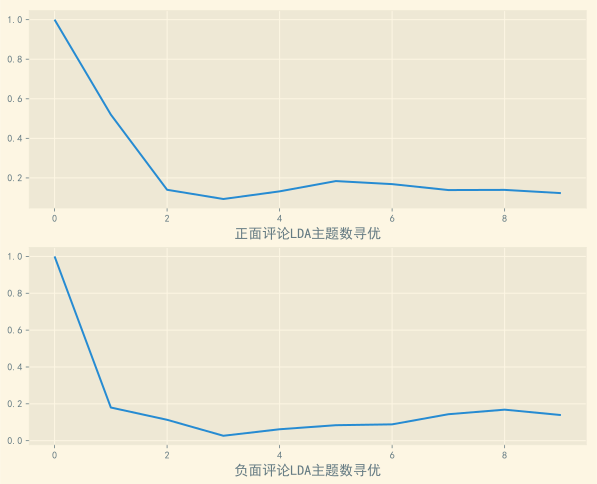

In [145]:
# 构造主题数寻优函数
def cos(vector1, vector2):  # 余弦相似度函数
    dot_product = 0.0;
    normA = 0.0;
    normB = 0.0;
    for a, b in zip(vector1, vector2):
        dot_product += a * b
        normA += a ** 2
        normB += b ** 2
    if normA == 0.0 or normB == 0.0:
        return (None)
    else:
        return (dot_product / ((normA * normB) ** 0.5))

    # 主题数寻优


def lda_k(x_corpus, x_dict):
    # 初始化平均余弦相似度
    mean_similarity = []
    mean_similarity.append(1)

    # 循环生成主题并计算主题间相似度
    for i in np.arange(2, 11):
        lda = models.LdaModel(x_corpus, num_topics=i, id2word=x_dict)  # LDA模型训练
        for j in np.arange(i):
            term = lda.show_topics(num_words=50)

        # 提取各主题词
        top_word = []
        for k in np.arange(i):
            top_word.append([''.join(re.findall('"(.*)"', i)) \
                             for i in term[k][1].split('+')])  # 列出所有词

        # 构造词频向量
        word = sum(top_word, [])  # 列出所有的词
        unique_word = set(word)  # 去除重复的词

        # 构造主题词列表，行表示主题号，列表示各主题词
        mat = []
        for j in np.arange(i):
            top_w = top_word[j]
            mat.append(tuple([top_w.count(k) for k in unique_word]))

        p = list(itertools.permutations(list(np.arange(i)), 2))
        l = len(p)
        top_similarity = [0]
        for w in np.arange(l):
            vector1 = mat[p[w][0]]
            vector2 = mat[p[w][1]]
            top_similarity.append(cos(vector1, vector2))

        # 计算平均余弦相似度
        mean_similarity.append(sum(top_similarity) / l)
    return (mean_similarity)

# 计算主题平均余弦相似度
pos_k = lda_k(pos_corpus, pos_dict)
neg_k = lda_k(neg_corpus, neg_dict)

# 绘制主题平均余弦相似度图形
font = FontProperties(size=14)

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax1.plot(pos_k)
ax1.set_xlabel('正面评论LDA主题数寻优', fontproperties=font)

ax2 = fig.add_subplot(212)
ax2.plot(neg_k)
ax2.set_xlabel('负面评论LDA主题数寻优', fontproperties=font)

plt.show()

评价主题分析结果
设置主题数为3，因为从3开始趋于平稳每个主题下生成10个最有可能出现的词语以及相应的概率

In [167]:
# LDA主题分析
pos_lda = models.LdaModel(pos_corpus, num_topics = 3, id2word = pos_dict)
neg_lda = models.LdaModel(neg_corpus, num_topics = 3, id2word = neg_dict)
pos_topic = pos_lda.print_topics(num_words = 10)
neg_topic = neg_lda.print_topics(num_words = 10)

In [174]:
pos_theme = []
for p in pos_topic:
    word = re.findall('\*"(.*?)"',p[1])
    pos_theme.append(word)
pos_theme

[['玩', '好玩', '不错', '感觉', '推荐', '第一次', '翻船', '点', '冷', '时间'],
 ['刺激', '喜欢', '漂', '值得', '天气', '服务', '体验', '设施', '赞', '一点'],
 ['值得', '地方', '真的', '朋友', '满意', '水', '太', '还好', '小时', '工作人员']]

In [175]:
neg_theme = []
for p in neg_topic:
    word = re.findall('\*"(.*?)"',p[1])
    neg_theme.append(word)
neg_theme

[['水', '服务', '贵', '吃', '加气', '长', '点', '好玩', '景区', '钱'],
 ['不好', '差', '免费', '设施', '维护', '洗澡', '真的', '坑', '不错', '高'],
 ['刺激', '地方', '冷', '太', '垃圾', '工作人员', '消费', '门票', '时间', '装备']]